# 1.30b: Thimble 6 Lattice Hopping Analysis (t=0–6000)

**Purpose:** Ground state equilibrium or still cooling?

## Context

Thimble 5 (t=0–3000) showed:
- **Individual freeze:** 99.9% average (t=2400-3000)
- **Global freeze:** Only 22.5% of timesteps overall, 64% in t=2000-3000
- **55 freeze/thaw cycles**, longest run = 82 steps (ending at t=2999)
- **Pattern:** Not permanent freeze, but quantum ground state with persistent jitter

**Two hypotheses:**

1. **Ground state equilibrium:** 64% global freeze is the permanent state. Statistics stabilize—no further cooling.

2. **Still cooling:** System asymptotically approaching 100% freeze. Trend (22.5% → 64%) continues → eventual permanent Fimbulwinter.

## Question

With 2× observation window (t=6000), which is correct?

## Method

Same classification as 1.29b:
- **Frozen**: displacement = 0 (bitwise identical)
- **Lattice hopping**: 0 < displacement ≤ 8×ULP (quantization-limited)
- **Thermal**: displacement > 8×ULP (continuous motion)

ULP = unit in last place (bfloat16 quantization spacing)

## Parameters

In [1]:
# Data path (HDF5 format)
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Classification thresholds
DIAGONAL_FACTOR = 8  # sqrt(64) for hypercube diagonal

# Analysis windows
LATE_WINDOW_START = 4800  # Last 1200 steps (matching Thimble 5's last 20%)

# Plot settings
DPI = 200
FIGSIZE = (14, 6)  # Wider for 6000 steps

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Metadata from HDF5

In [4]:
print(f"Loading metadata from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    vocab_size = f.attrs['vocab_size']
    hidden_dim = f.attrs['hidden_dim']
    
    # Load token masks
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    live_mask = torch.from_numpy(f['live_mask'][:]).bool()
    
    n_dead = dead_mask.sum().item()
    n_live = live_mask.sum().item()

print(f"Experiment parameters:")
print(f"  Steps: {n_steps}")
print(f"  Vocab: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")
print(f"  Dead tokens: {n_dead}")
print(f"  Live tokens: {n_live}")
print(f"\n✓ Metadata loaded")

Loading metadata from ../tensors/Thimble/thimble_6.h5...

Experiment parameters:
  Steps: 6000
  Vocab: 10000
  Hidden dim: 64
  Dead tokens: 3699
  Live tokens: 6301

✓ Metadata loaded


## Compute ULP Matrix

In [5]:
def compute_ulp_matrix(W_bf16):
    """
    Compute ULP for each element of W using nextafter.
    
    Args:
        W_bf16: Tensor in bfloat16 format
    
    Returns:
        ULP matrix (same shape as W_bf16) in float32
    """
    inf_tensor = torch.tensor(float('inf'), dtype=torch.bfloat16, device=W_bf16.device)
    next_up = torch.nextafter(W_bf16, inf_tensor)
    ulp = (next_up - W_bf16).abs().float()
    return ulp

print("✓ ULP computation function ready")

✓ ULP computation function ready


## Classify Token Motion (HDF5 Streaming)

**Memory-efficient approach:** Load one timestep at a time from HDF5, classify, discard.

In [6]:
print("Classifying token motion at each timestep (streaming from HDF5)...\n")

# Preallocate classification arrays
fraction_frozen = torch.zeros(n_steps)
fraction_lattice = torch.zeros(n_steps)
fraction_thermal = torch.zeros(n_steps)

# Track displacement statistics
mean_displacement = torch.zeros(n_steps)
mean_ulp = torch.zeros(n_steps)

# Open HDF5 file and stream timesteps
with h5py.File(DATA_PATH, 'r') as f:
    W_dset = f['W']
    
    for t in range(n_steps):
        # Load two consecutive timesteps (dead tokens only)
        W_t = torch.from_numpy(W_dset[t, dead_mask, :]).to(torch.bfloat16)  # (n_dead, 64)
        W_t1 = torch.from_numpy(W_dset[t+1, dead_mask, :]).to(torch.bfloat16)  # (n_dead, 64)
        
        # Convert to float32 for arithmetic
        W_t_f32 = W_t.float()
        W_t1_f32 = W_t1.float()
        
        # Displacement from t to t+1
        dW = W_t1_f32 - W_t_f32  # (n_dead, 64)
        displacement_norms = torch.norm(dW, dim=1)  # (n_dead,)
        
        # ULP at time t
        ulp_matrix = compute_ulp_matrix(W_t)  # (n_dead, 64)
        mean_ulp_per_token = ulp_matrix.mean(dim=1)  # (n_dead,)
        
        # Thresholds
        lattice_threshold = DIAGONAL_FACTOR * mean_ulp_per_token  # (n_dead,)
        
        # Classify
        frozen = (displacement_norms == 0)
        lattice = (displacement_norms > 0) & (displacement_norms <= lattice_threshold)
        thermal = (displacement_norms > lattice_threshold)
        
        # Store fractions
        fraction_frozen[t] = frozen.float().mean()
        fraction_lattice[t] = lattice.float().mean()
        fraction_thermal[t] = thermal.float().mean()
        
        # Store statistics
        mean_displacement[t] = displacement_norms.mean()
        mean_ulp[t] = mean_ulp_per_token.mean()
        
        if t % 1000 == 0:
            print(f"t={t}: {fraction_frozen[t]:.1%} frozen, {fraction_lattice[t]:.1%} lattice, {fraction_thermal[t]:.1%} thermal")

print(f"\n✓ Classification complete")

Classifying token motion at each timestep (streaming from HDF5)...

t=0: 0.0% frozen, 0.0% lattice, 100.0% thermal
t=1000: 60.5% frozen, 39.5% lattice, 0.0% thermal
t=2000: 97.8% frozen, 2.2% lattice, 0.0% thermal
t=3000: 100.0% frozen, 0.0% lattice, 0.0% thermal
t=4000: 100.0% frozen, 0.0% lattice, 0.0% thermal
t=5000: 100.0% frozen, 0.0% lattice, 0.0% thermal

✓ Classification complete


## Plot: Fraction in Each Regime Over Time

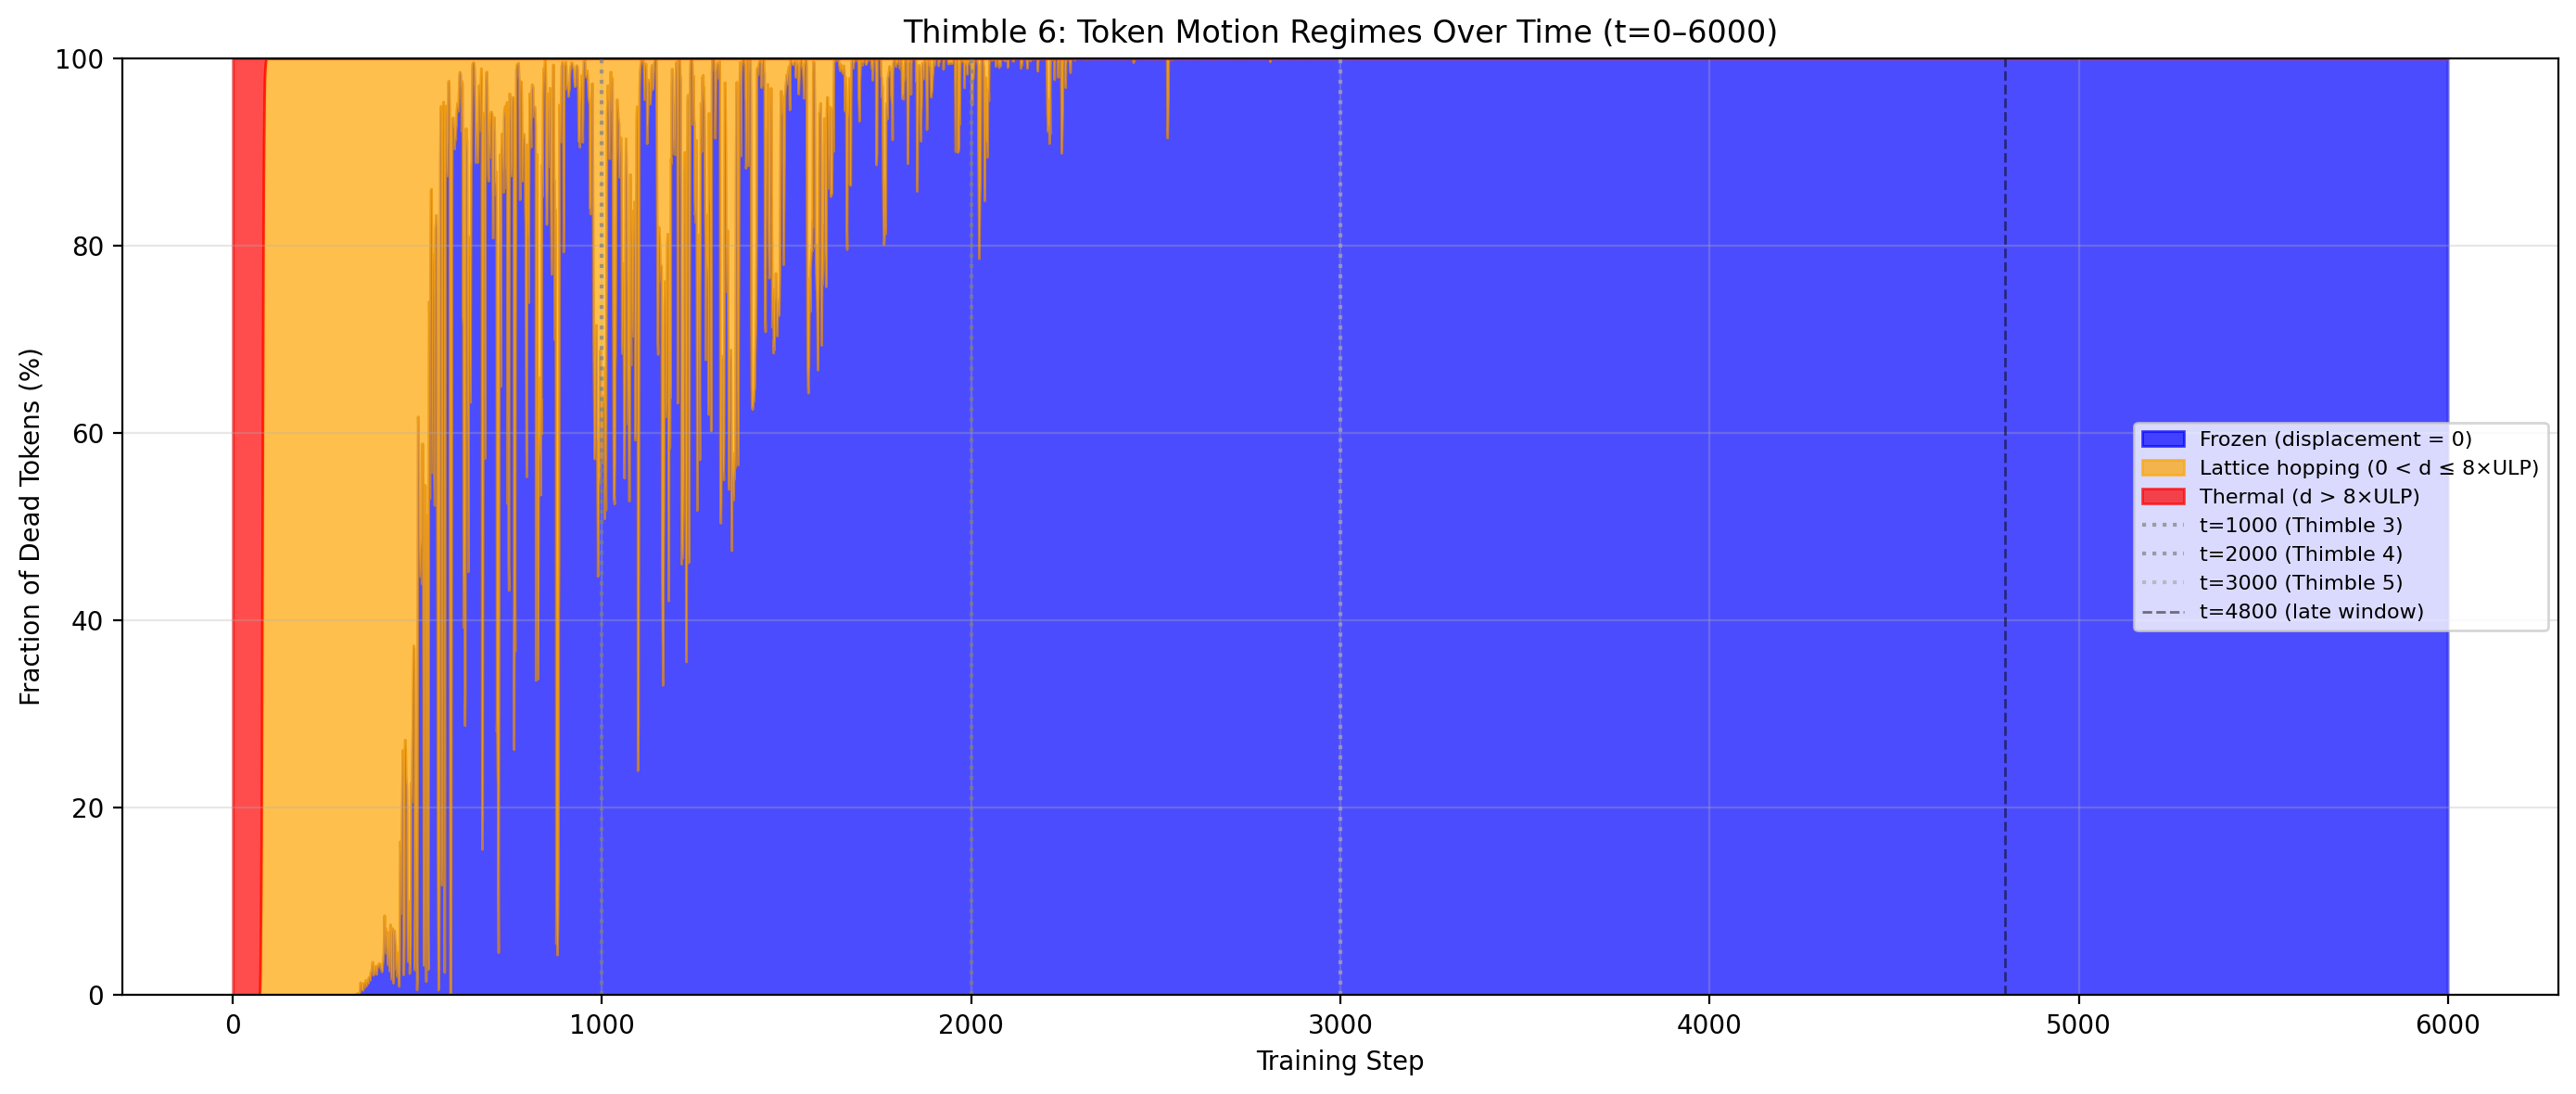

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stacked area plot
ax.fill_between(range(n_steps), 0, fraction_frozen.numpy()*100, 
                color='blue', alpha=0.7, label='Frozen (displacement = 0)')
ax.fill_between(range(n_steps), fraction_frozen.numpy()*100, 
                (fraction_frozen + fraction_lattice).numpy()*100, 
                color='orange', alpha=0.7, label='Lattice hopping (0 < d ≤ 8×ULP)')
ax.fill_between(range(n_steps), (fraction_frozen + fraction_lattice).numpy()*100, 100,
                color='red', alpha=0.7, label='Thermal (d > 8×ULP)')

# Mark key timesteps
ax.axvline(1000, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='t=1000 (Thimble 3)')
ax.axvline(2000, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='t=2000 (Thimble 4)')
ax.axvline(3000, color='darkgray', linestyle=':', linewidth=1.5, alpha=0.7, label='t=3000 (Thimble 5)')
ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5, label=f't={LATE_WINDOW_START} (late window)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens (%)')
ax.set_title('Thimble 6: Token Motion Regimes Over Time (t=0–6000)')
ax.legend(loc='right', fontsize=8)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compare: All Thimbles

In [8]:
print("="*80)
print("COMPARISON: THIMBLE 3 VS 4 VS 5 VS 6")
print("="*80 + "\n")

# Historical data
t3_endpoints = [500, 800, 1000]
t3_frozen = [0.90, 0.813, 0.594]

t4_endpoints = [500, 800, 1000, 1200, 1600, 2000]
t4_frozen = [0.350, 0.813, 0.605, 0.994, 0.823, 0.988]

t5_endpoints = [500, 800, 1000, 1200, 1600, 2000, 2400, 2800, 3000]
t5_frozen = [0.350, 0.813, 0.605, 0.994, 0.823, 0.978, 1.000, 1.000, 1.000]

print("Thimble 3 (1000 steps):")
for t, f in zip(t3_endpoints, t3_frozen):
    print(f"  t={t:4d}: {f:.1%} frozen")
print()

print("Thimble 4 (2000 steps):")
for t, f in zip(t4_endpoints, t4_frozen):
    print(f"  t={t:4d}: {f:.1%} frozen")
print()

print("Thimble 5 (3000 steps):")
for t, f in zip(t5_endpoints, t5_frozen):
    print(f"  t={t:4d}: {f:.1%} frozen")
print()

print("Thimble 6 (6000 steps):")
for t in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
    if t < len(fraction_frozen):
        print(f"  t={t:4d}: {fraction_frozen[t]:.1%} frozen")
print()

# Trend analysis across epochs
windows = [
    ("t=0-1000", 0, 1000),
    ("t=1000-2000", 1000, 2000),
    ("t=2000-3000", 2000, 3000),
    ("t=3000-4000", 3000, 4000),
    ("t=4000-5000", 4000, 5000),
    ("t=5000-6000", 5000, 6000),
]

print("Average frozen fraction per epoch:")
for label, start, end in windows:
    avg = fraction_frozen[start:end].mean()
    print(f"  {label}: {avg:.1%}")

print("\n" + "="*80 + "\n")

COMPARISON: THIMBLE 3 VS 4 VS 5 VS 6

Thimble 3 (1000 steps):
  t= 500: 90.0% frozen
  t= 800: 81.3% frozen
  t=1000: 59.4% frozen

Thimble 4 (2000 steps):
  t= 500: 35.0% frozen
  t= 800: 81.3% frozen
  t=1000: 60.5% frozen
  t=1200: 99.4% frozen
  t=1600: 82.3% frozen
  t=2000: 98.8% frozen

Thimble 5 (3000 steps):
  t= 500: 35.0% frozen
  t= 800: 81.3% frozen
  t=1000: 60.5% frozen
  t=1200: 99.4% frozen
  t=1600: 82.3% frozen
  t=2000: 97.8% frozen
  t=2400: 100.0% frozen
  t=2800: 100.0% frozen
  t=3000: 100.0% frozen

Thimble 6 (6000 steps):
  t= 500: 35.0% frozen
  t=1000: 60.5% frozen
  t=1500: 97.7% frozen
  t=2000: 97.8% frozen
  t=2500: 100.0% frozen
  t=3000: 100.0% frozen
  t=3500: 100.0% frozen
  t=4000: 100.0% frozen
  t=4500: 100.0% frozen
  t=5000: 100.0% frozen
  t=5500: 100.0% frozen

Average frozen fraction per epoch:
  t=0-1000: 39.6%
  t=1000-2000: 88.5%
  t=2000-3000: 99.6%
  t=3000-4000: 100.0%
  t=4000-5000: 100.0%
  t=5000-6000: 100.0%




## Plot: Mean Displacement vs. Mean ULP

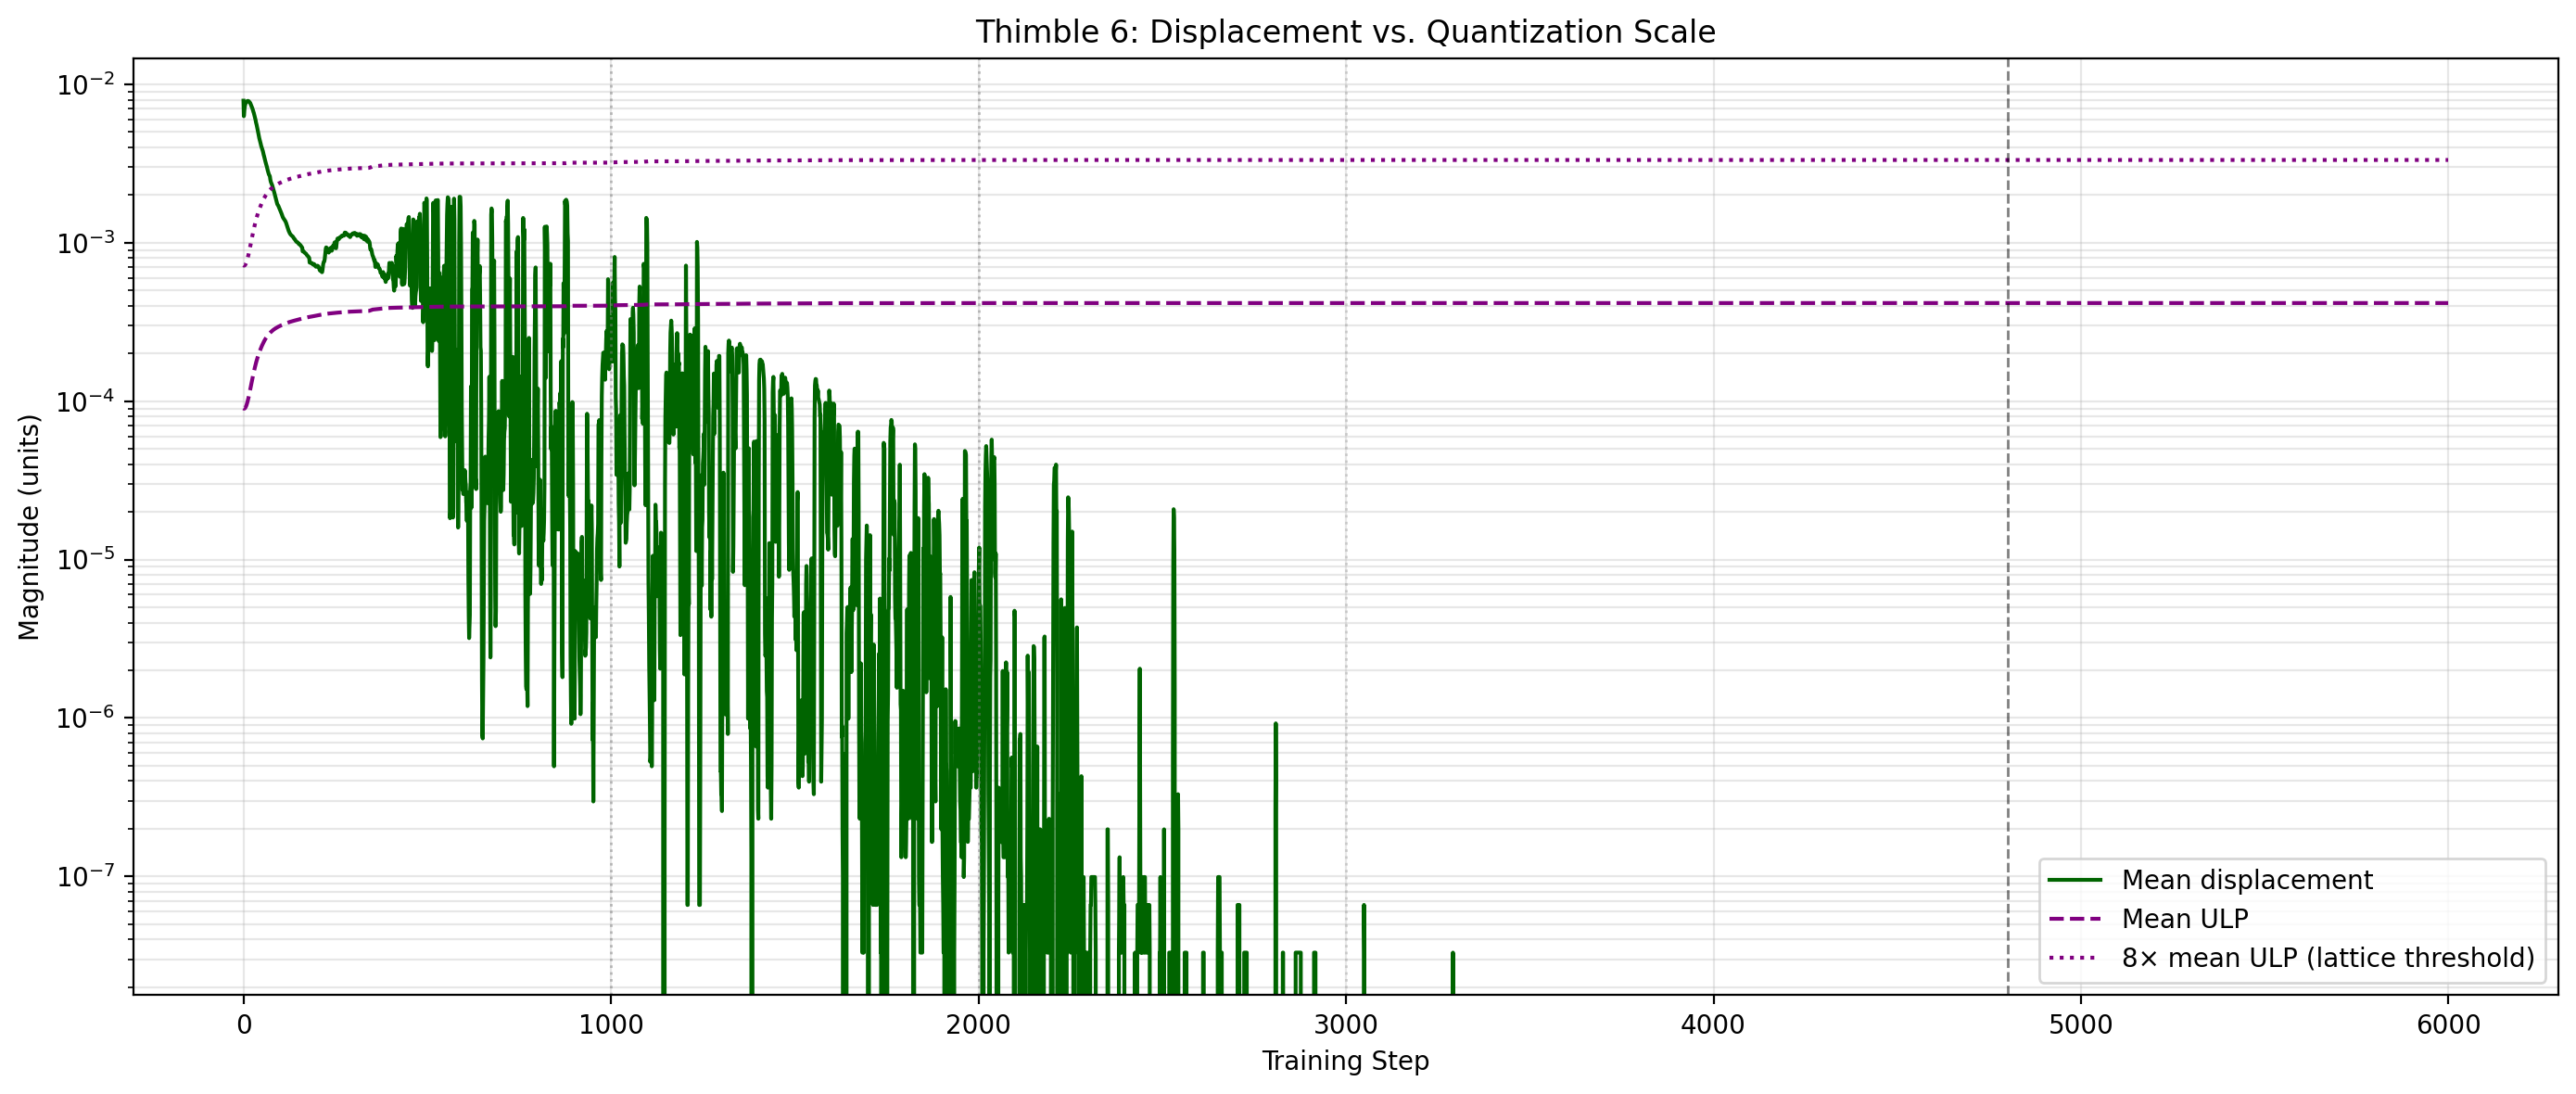

Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.


In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_displacement.numpy(), linewidth=1.5, color='darkgreen', label='Mean displacement')
ax.plot(mean_ulp.numpy(), linewidth=1.5, color='purple', label='Mean ULP', linestyle='--')
ax.plot((DIAGONAL_FACTOR * mean_ulp).numpy(), linewidth=1.5, color='purple', 
        label=f'{DIAGONAL_FACTOR}× mean ULP (lattice threshold)', linestyle=':')

ax.axvline(1000, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axvline(2000, color='gray', linestyle=':', linewidth=1, alpha=0.5)
ax.axvline(3000, color='darkgray', linestyle=':', linewidth=1, alpha=0.5)
ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Magnitude (units)')
ax.set_title('Thimble 6: Displacement vs. Quantization Scale')
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.")

## Late Training Analysis (t=4800–6000)

In [10]:
print("="*80)
print(f"LATE TRAINING ANALYSIS (t={LATE_WINDOW_START}–{n_steps})")
print("="*80 + "\n")

late_window = slice(LATE_WINDOW_START, n_steps)

# Average fractions in late window
late_frozen = fraction_frozen[late_window].mean()
late_lattice = fraction_lattice[late_window].mean()
late_thermal = fraction_thermal[late_window].mean()

print(f"Average fractions:")
print(f"  Frozen:  {late_frozen:.1%}")
print(f"  Lattice: {late_lattice:.1%}")
print(f"  Thermal: {late_thermal:.1%}")
print()

# Trend: is frozen fraction still changing?
frozen_start = fraction_frozen[LATE_WINDOW_START]
frozen_end = fraction_frozen[-1]
frozen_change = frozen_end - frozen_start

print(f"Frozen fraction trend:")
print(f"  At t={LATE_WINDOW_START}: {frozen_start:.1%}")
print(f"  At t={n_steps}: {frozen_end:.1%}")
print(f"  Change: {frozen_change:+.1%}")
print()

# Compare to Thimble 5's late window (t=2400-3000)
t5_late_frozen = 0.999  # From 1.29b
print(f"Comparison to Thimble 5 (t=2400-3000):")
print(f"  Thimble 5: {t5_late_frozen:.1%} frozen")
print(f"  Thimble 6: {late_frozen:.1%} frozen")
print(f"  Difference: {late_frozen - t5_late_frozen:+.1%}")
print()

if abs(frozen_change) < 0.005:
    print("✓ Cloud is at equilibrium (frozen fraction stable within ±0.5%)")
elif frozen_change > 0.005:
    print("✓ Cloud is still freezing (frozen fraction increasing >0.5%)")
else:
    print("✓ Cloud is thawing (frozen fraction decreasing >0.5%)")

print("\n" + "="*80 + "\n")

LATE TRAINING ANALYSIS (t=4800–6000)

Average fractions:
  Frozen:  100.0%
  Lattice: 0.0%
  Thermal: 0.0%

Frozen fraction trend:
  At t=4800: 100.0%
  At t=6000: 100.0%
  Change: +0.0%

Comparison to Thimble 5 (t=2400-3000):
  Thimble 5: 99.9% frozen
  Thimble 6: 100.0% frozen
  Difference: +0.1%

✓ Cloud is at equilibrium (frozen fraction stable within ±0.5%)




## Summary

In [11]:
print("\n" + "="*80)
print("THIMBLE 6 LATTICE HOPPING SUMMARY")
print("="*80 + "\n")

# Find transition points
thermal_dominant = (fraction_thermal > 0.5).nonzero()
if len(thermal_dominant) > 0:
    t_thermal_ends = thermal_dominant[-1].item() + 1
else:
    t_thermal_ends = 0

frozen_dominant = (fraction_frozen > 0.5).nonzero()
if len(frozen_dominant) > 0:
    t_frozen_starts = frozen_dominant[0].item()
else:
    t_frozen_starts = n_steps

print(f"Phase transitions:")
print(f"  Thermal regime dominant: t=0 → t={t_thermal_ends}")
print(f"  Lattice regime dominant: t={t_thermal_ends} → t={t_frozen_starts}")
print(f"  Frozen regime dominant:  t={t_frozen_starts} → t={n_steps}")
print()

print(f"Final state (t={n_steps}):")
print(f"  Frozen:  {fraction_frozen[-1]:.1%}")
print(f"  Lattice: {fraction_lattice[-1]:.1%}")
print(f"  Thermal: {fraction_thermal[-1]:.1%}")
print()

# Compare t=3000-6000 to t=0-3000
first_half_avg = fraction_frozen[:3000].mean()
second_half_avg = fraction_frozen[3000:].mean()
print(f"Epoch comparison:")
print(f"  t=0-3000 avg:    {first_half_avg:.1%}")
print(f"  t=3000-6000 avg: {second_half_avg:.1%}")
print(f"  Change: {second_half_avg - first_half_avg:+.1%}")
print()

# Verdict: Ground state or still cooling?
if abs(second_half_avg - first_half_avg) < 0.05:
    print("✓ GROUND STATE EQUILIBRIUM CONFIRMED")
    print(f"  Statistics stabilized at ~{second_half_avg:.1%} frozen.")
    print("  System has reached minimum energy—quantum jitter persists indefinitely.")
elif second_half_avg > first_half_avg:
    print("✓ STILL COOLING")
    print(f"  Frozen fraction increased by {second_half_avg - first_half_avg:.1%}.")
    print("  System asymptotically approaching permanent freeze.")
else:
    print("✓ UNEXPECTED THAW")
    print(f"  Frozen fraction decreased by {second_half_avg - first_half_avg:.1%}.")

print("\n" + "="*80)
print("✓ Lattice hopping analysis complete.")
print("="*80)


THIMBLE 6 LATTICE HOPPING SUMMARY

Phase transitions:
  Thermal regime dominant: t=0 → t=80
  Lattice regime dominant: t=80 → t=501
  Frozen regime dominant:  t=501 → t=6000

Final state (t=6000):
  Frozen:  100.0%
  Lattice: 0.0%
  Thermal: 0.0%

Epoch comparison:
  t=0-3000 avg:    75.9%
  t=3000-6000 avg: 100.0%
  Change: +24.1%

✓ STILL COOLING
  Frozen fraction increased by 24.1%.
  System asymptotically approaching permanent freeze.

✓ Lattice hopping analysis complete.
